  # DIY

  This notebook shows how to customize the heater/condenser and ohp configuration

  # Packages

  Firstly, let's import the necessary packages, you may need to install them
  for the first time.

In [1]:
using OscillatingHeatPipe # our main package
using Plots # for plotting
using ProgressMeter # to have a progress bar in the calculation

  # Specify properties

  ### Solid Physical parameters

  The numbers below represent aluminum alloy 3003

In [2]:
ρₛ = 2730; # material density [kg/m^3]
cₛ  = 8.93e02; # material specific heat [J/kg K]
kₛ  = 1.93e02; # material heat conductivity [W/m K]
plate_d = 1.5e-3; # effective d [m] (The thickness of an ideal uniform thickness plate occupying the same volume)
αₛ = kₛ/ρₛ/cₛ

Tref = 291.2 # reference temperature [K]

power = 70 # [W], total power
Lheater_x = 50e-3 # [m], length of heater along x axis
Lheater_y = 50e-3 # [m], length of heater along y axis
areaheater_area = Lheater_x * Lheater_y # [m^2] total area

phys_params = Dict( "diffusivity"              => αₛ,
                    "flux_correction"          => ρₛ*cₛ*plate_d,
                    "Fourier"                  => 1.0,
                    "ohp_flux"                 => [NaN], # initial value, the value here is useless
                    "areaheater_power"         => power, # total power
                    "areaheater_area"          => areaheater_area, # total area
                    "areaheater_temp"          => 0.0,   # relative temperature compared with "background temperature"
                    "areaheater_coeff"         => 4000.0,
                    "background temperature"   => Tref
                     )

Dict{String, Any} with 9 entries:
  "areaheater_coeff"       => 4000.0
  "Fourier"                => 1.0
  "flux_correction"        => 3656.84
  "ohp_flux"               => [NaN]
  "diffusivity"            => 7.91668e-5
  "areaheater_area"        => 0.0025
  "areaheater_power"       => 70
  "areaheater_temp"        => 0.0
  "background temperature" => 291.2

  ### Fluid Physical parameters

  Here, we set the p_fluid contains the vapor and liquid properties at a constant reference
  temperature. Noted that the vapor pressure and the vapor density will be
  functions of temperatures during the simulation, other properties are
  extracted from pfluid as an approximate value.

In [3]:
fluid_type = "Butane"
p_fluid = SaturationFluidProperty(fluid_type,Tref)

Saturation properties for Butane at constant temperature 291.2 [K]


  # Set the geometries

  ### Geometry parameters

  The 2D domain is of rectangular shape (slightly different from ASETS-II). In
  the future it can be of arbitrary shape using the immersedlayers.jl package.

In [4]:
Δx = 0.0007 # [m] # grid size, at the same order of 1D OHP channel node spacing ~ 0.001[m]
Lx = 6*INCHES*1.02; # plate size x [m]
Ly = 2*INCHES*1.05; # plate size y [m]
xlim = (-Lx/2,Lx/2) # plate x limits
ylim = (-Ly/2,Ly/2) # plate y limits

g = PhysicalGrid(1.03 .* xlim,1.1 .* ylim,Δx) # build a gird slightly larger than the plate

xbound = [ -Lx/2,-Lx/2,
            Lx/2, Lx/2] # x coordinates of the shape

ybound = [  Ly/2,-Ly/2,
           -Ly/2, Ly/2] # y coordinates of the shape

Δs = 1.4*cellsize(g)
body = Polygon(xbound,ybound,Δs)

X = MotionTransform([0,0],0) # move the plate or rotate the plate
joint = Joint(X)
m = RigidBodyMotion(joint,body)
x = zero_motion_state(body,m)
update_body!(body,x,m)

function get_qbplus(t,x,base_cache,phys_params,motions)
    nrm = normals(base_cache)
    qbplus = zeros_surface(base_cache)
    return qbplus
end

function get_qbminus(t,x,base_cache,phys_params,motions)
    nrm = normals(base_cache)
    qbminus = zeros_surface(base_cache)
    return qbminus
end

bcdict = Dict("exterior" => get_qbplus,"interior" => get_qbminus)

Dict{String, Function} with 2 entries:
  "interior" => get_qbminus
  "exterior" => get_qbplus

  # Set up the evaporators and condensers

  In the "OHP simulation" notebook, I use "OHPtype" to look up a preset dictionary of OHP evaporators and condensers.

  You can also customize them, following the procedure below in this notebook.

  Firstly let's give the total heater power

In [5]:
function heatermodel!(σ,T,t,fr::AreaRegionCache,phys_params)
    σ .= phys_params["areaheater_power"] / phys_params["areaheater_area"] / phys_params["flux_correction"]
end

function condensermodel!(σ,T,t,fr::AreaRegionCache,phys_params)
    T0 = phys_params["areaheater_temp"]
    h = phys_params["areaheater_coeff"]
    corr = phys_params["flux_correction"]

    σ .= h*(T0 - T) / corr
end

condensermodel! (generic function with 1 method)

Then let's construct a heater

In [6]:
eb1 = Rectangle(Lheater_x/2,Lheater_x/2,1.4*Δx)
tr1_h = RigidTransform((0.0,-0.0),0.0)
heater1 = AreaForcingModel(eb1,tr1_h,heatermodel!);

Then let's consctruct a condenser

In [7]:
Lcondenser_x = 15e-3
Lcondenser_y = 1.0INCHES
cb1 = Rectangle(Lcondenser_x,Lcondenser_y,1.4*Δx)
tr1_c = RigidTransform((2.4INCHES,-0.0),0.0)
cond1 = AreaForcingModel(cb1,tr1_c,condensermodel!);

# Set up OHP channel's shape

Similarly, In the "OHP simulation" notebook, I used **construct_ohp_curve("ASETS",Δx)** to look up a preset dictionary of ASETS-II OHP.

You can customize the ohp curve in either of the two ways:

 1. simply supply two arrays of x and y of the same length:

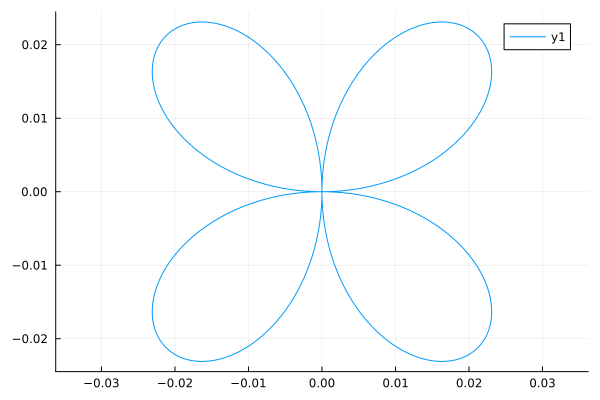

In [8]:
a = 0.03
θ = 0:2π/1000:2π
r = a*sin.(2θ)
x = r .* cos.(θ)
y = r .* sin.(θ);

plot(x,y,aspectratio=1)

2. **construct_ohp_curve(nturn, pitch, height, gap, ds, x0, y0, flipx, flipy, angle)**, a built-in function to generate a closed loop multi-turn channel

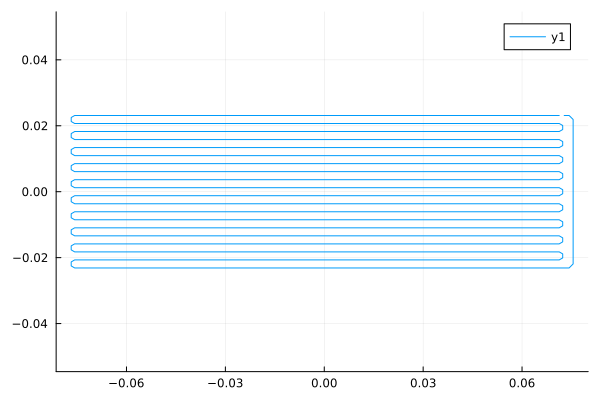

In [9]:
ds = 1.5Δx # point interval
nturn = 9 # number of turns
width_ohp = 46.25*1e-3
length_ohp = 147.0*1e-3
gap = 3e-3 # gap between the closed loop end to the channel(not the distance between each channels)
pitch = width_ohp/(2*nturn+1) # pitch between channels
rotation_angle = 3π/2
x0, y0 = length_ohp/2 + 2e-3, width_ohp/2

x,y, xf, yf = construct_ohp_curve(nturn,pitch,length_ohp,gap,ds,x0,y0,false,false,rotation_angle)

plot(x,y,aspectratio=1)

Now set the coordinates into a "body", which allows us to transform it in various helpful ways.
Here, we will just place it at the origin

In [10]:
ohp = BasicBody(x,y) # build a BasicBody based on x,y
tr_ohp = RigidTransform((0.0,0.0),0.0)

2d motion transform, x = [0.0, 0.0], R = [1.0 0.0; -0.0 1.0]

We also need a function that will introduce the OHP heat flux into the plate

In [11]:
function ohpmodel!(σ,T,t,fr::LineRegionCache,phys_params)
    σ .= phys_params["ohp_flux"] ./ phys_params["flux_correction"]
end
ohp_linesource = LineForcingModel(ohp,tr_ohp,ohpmodel!);

  ### Plot what you have so far

  This is a exmaple of the compuational domain (the box) and the OHP channel
  serpentine (in blue)

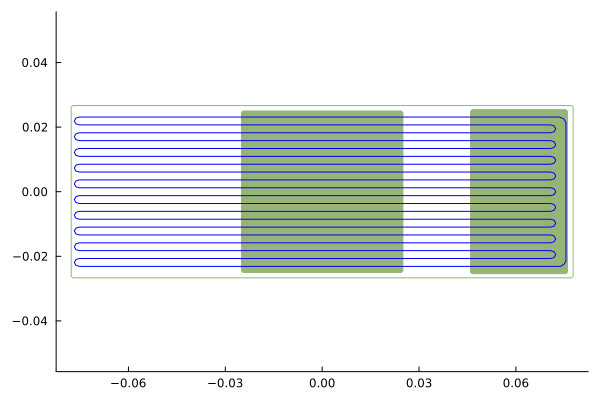

In [12]:
plot(body,fillalpha=0)
update_body!(eb1,tr1_h)
update_body!(cb1,tr1_c)
plot!(eb1)
plot!(cb1)
update_body!(ohp,tr_ohp)

plot!(ohp,fillalpha=0,closedornot=true)

 Assemble into a forcing list

In [13]:
forcing_dict = Dict("heating models" => [heater1,cond1,ohp_linesource])

Dict{String, Vector{AbstractForcingModel}} with 1 entry:
  "heating models" => [AreaForcingModel{Polygon{204, 4, ClosedBody}, MotionTran…

  # Construct the systems
Now we will set up the thermal conduction problem, and then set up the data structures
for the plate and OHP channels

 ### Set time step
We first set the time step size (in seconds), and a function that will supply this time step.

In [14]:
tstep = 1e-3
timestep_fixed(u,sys) = tstep

timestep_fixed (generic function with 1 method)

### Create heat conduction system
The solid module dealing with the 2D conduction, evaporator, condenser, and
the OHP line heat source is constructed here.

In [15]:
prob = NeumannHeatConductionProblem(g,body,phys_params=phys_params,
                                           bc=bcdict,
                                           motions=m,
                                           forcing=forcing_dict,
                                           timestep_func=timestep_fixed);

The `sys_plate` structure contains everything about the plate

In [16]:
sys_plate = construct_system(prob);

 ### Create OHP channel system
 The `sys_tube` structure contains everything about the OHP channels and fluid

In [17]:
sys_tube = initialize_ohpsys(sys_plate,p_fluid,power);

 # Initialize the problem
We set intial conditions for the plate and channel here
For plate, the time span should be a range larger than the TOTAL time you plan to simulate (including saving and re-run),
if the range is smaller than the total time range, there will be errors in temperature interpolations

In [18]:
tspan_init = (0.0,1e4)
u_plate = init_sol(sys_plate)# initialize plate T field to uniform Tref
integrator_plate = init(u_plate,tspan_init,sys_plate,save_on=false) # construct integrator_plate

t: 0.0
u: (Primal nodes in a (nx = 234, ny = 88) cell grid of type Float64 data
  Number of Primal nodes: (nx = 233, ny = 87), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0])

Set the tubes time span for simulation and its initial condition

In [19]:
tspan = (0.0, 1.0); # start time and end time
dt_record = 0.2   # saving time interval
u_tube = newstate(sys_tube) # initialize OHP tube
integrator_tube = init(u_tube,tspan,sys_tube); # construct integrator_tube

  ### initialize arrays for saving

In [20]:
SimuResult = SimulationResult(integrator_tube,integrator_plate);

  # Solve
  Run the simulation and store data

In [21]:
@showprogress for t in tspan[1]:tstep:tspan[2]

    timemarching!(integrator_tube,integrator_plate,tstep)

    if (mod(integrator_plate.t,dt_record) < 1e-6) || (mod(-integrator_plate.t,dt_record) < 1e-6)
        store!(SimuResult,integrator_tube,integrator_plate)
    end

end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


  # Store data

In [22]:
#save_path = "../numedata/solution.jld2"
#save(save_path,"SimulationResult",SimuResult)

### take a peek at the solution (more at the PostProcessing notebook)
First, a movie of temperature in the plate

[ Info: Saved animation to /var/folders/d5/yrzwk1z11mjcdnl51v1kfp8m0000gn/T/jl_lGP6TchcZI.gif


Plots.AnimatedGif("/var/folders/d5/yrzwk1z11mjcdnl51v1kfp8m0000gn/T/jl_lGP6TchcZI.gif")
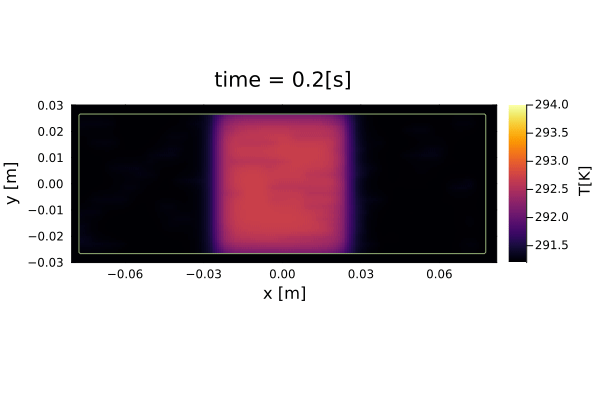

In [23]:
@gif for i in eachindex(SimuResult.tube_hist_t)
    plot(OHPTemp(),i,SimuResult,clim=(291.2,294.0))
    plot!(body,fillalpha=0)
end

Show a movie of the channels and the locations of slugs/film vapor/dry vapor

[ Info: Saved animation to /var/folders/d5/yrzwk1z11mjcdnl51v1kfp8m0000gn/T/jl_vkVs9gdCve.gif


Plots.AnimatedGif("/var/folders/d5/yrzwk1z11mjcdnl51v1kfp8m0000gn/T/jl_vkVs9gdCve.gif")
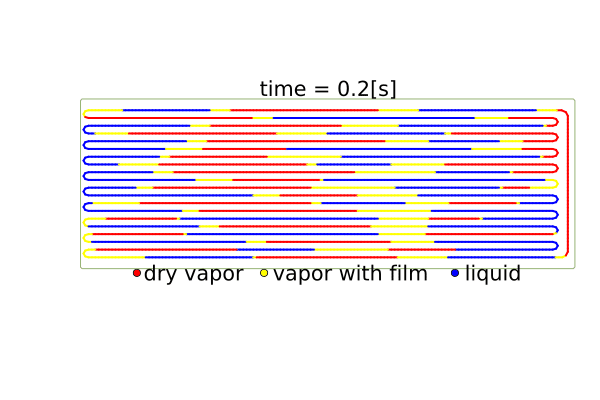

In [24]:
@gif for i in eachindex(SimuResult.tube_hist_t)
    plot(OHPSlug(),i,SimuResult,aspectratio=1)
    plot!(body,fillalpha=0)
end

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*